## Three-dimensional hyperbolic systems

### Navier Stokes equation in 3d

First we are going to study the three-dimensional Navier-Stokes equation 
\begin{align}
    \frac{\partial}{\partial t} n &= - \nabla\cdot\left( nu\vec { b}\right) \\
    \frac{\partial}{\partial t} u &= - \nabla_\parallel\left(\frac{u^2}{2}\right) - \frac{\tau}{\mu} \frac{\nabla_\parallel n}{n} + \nu_u \frac{\Delta_\parallel u}{n}
\end{align}
with
\begin{align}
\Delta_\parallel u &= \nabla\cdot ( \vec {b}\vec {b}\cdot\nabla u)
\end{align} 
$\vec {b} = \vec {b}(\vec x)$ is the prescribed magnetic field unit vector,
and $\nu_u$ is the viscosity coefficient parallel to this field.

## Comments for Raul-3d
- equations should be like flags (I don't want to write out all of them)
- We should be able to suppress 3d output
- technically, MassCons without Basics won't work
- in tex the equations should be in output?

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
from scipy import ndimage

In [2]:
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenter.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
#                 "type" : "circle", # secret init condition in Feltor
#                 "sigma" : 0.2,
                "type" : "circle",
                "sigma" : 0.2,
                "amplitude" : 1.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "double-step", # secret non-symmetric init condition
                "sigma_z" : 1
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "type" : "none",
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "nu_parallel_n"  : 0.0,
        "order" : 2,
        "jfactor" : 1
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-4,
        "atol" : 1e-6,
        "output-mode" : "Tend",
        "reject-limit" : 2,
        "Tend" : 10
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["advection"]= {
        "type"  : "staggered-fieldaligned",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,0.0]
    inputfile["output"] = {
        "type" : "netcdf",
        "itstp" : 100,
        "maxout" : 1,
        "compression" : [1,1],
        "equations" : [
            "Basic"  ,
            "Mass-conserv",
            "Energy-theorem",
            #"Toroidal-momentum",
            "Parallel-momentum",
            #"Zonal-Flow-Energy",
            #"COCE"
        ]
    }
    inputfile["flags"] = []
    return inputfile

inputfile = create_inputfile()
print("magnetic_field", json.dumps( inputfile["magnetic_field"], indent=4,sort_keys=True))
print("init", json.dumps( inputfile["init"], indent=4,sort_keys=True))
print("advection", json.dumps( inputfile["advection"], indent=4,sort_keys=True))

magnetic_field {
    "curvmode": "toroidal",
    "input": "params",
    "params": {
        "I_0": 10.0,
        "R_0": 3.0,
        "comment": "Sine functions; Guenter et al, J. Comput. Phys. 209 (2005) 354",
        "description": "square",
        "equilibrium": "guenter"
    }
}
init {
    "aparallel": {
        "type": "zero"
    },
    "density": {
        "damping": {
            "type": "none"
        },
        "ntilde": {
            "amplitude": 1.0,
            "parallel": "double-step",
            "posX": 0.5,
            "posY": 0.0,
            "revolutions": 1,
            "rk4eps": 1e-06,
            "sigma": 0.2,
            "sigma_z": 1,
            "type": "circle"
        },
        "profile": {
            "background": 0.2,
            "type": "const"
        },
        "type": "ne"
    },
    "potential": {
        "type": "zero_pol"
    },
    "type": "fields",
    "velocity": {
        "type": "zero"
    }
}
advection {
    "slope-limiter": "none",
    "type"

In [3]:
rep = simplesim.Manager( executable="./feltor.sh", directory="ThreeDimensional/calibrate", filetype="nc")

In [4]:
# Define a plotting routine for the conservation equations
def plot_conservation( simfile, diagfile, plotfile, index):
    plt.rcParams.update({'font.size': 14})
    frows = 4
    fcols = 2
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.25*6,frows*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    dset = Dataset( diagfile, 'r', format="NETCDF4")
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(dset.inputfile)
    x = dset["x"][:]
    y = dset["y"][:]
    xc,yc = np.meshgrid( x, y)
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    ##
    time = dset['time'][:]
    timett = np.append( 2*time[0] -time[1]-2,time) # extrapolate
    deltat = np.diff(timett) # deltat_i = t[i] - t_[i-1]
    rho = dset['rho'][:]
    rho_t = dset['rho_t'][:]
    area = dset['psi_area'][:]
    volume = dset['psi_vol'][:]
    print( f"file : {simfile}")
    print( f"scheme = {pp['advection']['type']}", end=" ")
    print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
    print(f"time = {time[index]:5.2f}")
    gg = pp["grid"]
    fci = pp["FCI"]
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}", end='')
    print( f", nsteps: {simset['nsteps'][index]}, nfailed: {simset['failed'][index]}")
    
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    # Mass conservation
    print( f"Total mass conservation : {dset['ions_ifs_lcfs'][len(time)-1] - dset['ions_ifs_lcfs'][0]}")
    mass =dset['ions_fsa'][:,:]
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = dset['sni_tt_fsa'][:,:]/deltat[:,None]
    deltamass-=source

    
    divjvne=dset['divjnipar_tt_fsa'][:,:]/deltat[:,None]
    rhs =  divjvne
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 0
    cc = 1
    ax[rr][cc].plot( rho_t, average_diff, ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t, average_diff-average_std, 
                      average_diff+average_std, color='r', alpha=0.2)
#     handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
    ax[rr][cc].set_xlim([0.,1])
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 0
    cc = 0
    lower = 0.15
    upper = 0.225
    vo = simset['ions_2d'][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='jet' )
    ax[rr][cc].axis('scaled')
    
#     vo = plotset['ionsFF'][index,:,sectionY,:]
#     im = ax[rr][cc].pcolormesh(xfc2d,zfc2d,vo,vmin=lower,vmax=upper, shading='gouraud', cmap='gist_ncar_r' )

    ax[rr][cc].set_title("Mass")
    fig.colorbar( im , ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t, mass[index,:], ls = '-', color='r', lw = 4, label='mass')
#     ax[rr][cc].set_xlabel(r"$\rho_t$")
#     ax[rr][cc].legend()
    
    # Momentum conservation
    mom_con = dset['niui_ifs_lcfs'][len(time)-1] - dset['niui_ifs_lcfs'][0] \
     - dset['sparmirrori_tt_ifs_lcfs'][len(time)-1]
    print( f"Total momentum conservation :{mom_con}")
    momentum = dset['niui_fsa'][:,:] 
    momentumtt=np.append(np.zeros((1,len(rho))),momentum, axis=0)
    deltamomentum = np.diff(momentumtt,axis=0)/deltat[:,None]
    source = dset.variables['sei_tt_fsa'][:,:]/deltat[:,None]
    deltamomentum-=source
    
    divjpari=dset['divjpari_tt_fsa'][:,:]/deltat[:,None]
    force = dset['sparmirrori_tt_fsa'][:,:]/deltat[:,None]
    diff_para = dset["lparpar_tt_fsa"][:,:]/deltat[:,None]
    rhs =  - force - diff_para  + divjpari
    diff = (deltamomentum + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 1
    cc = 1
    ax[rr][cc].plot( rho_t, average_diff, ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t, average_diff-average_std, 
                      average_diff+average_std, color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
    ax[rr][cc].set_xlim([0,1])
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 1
    cc = 0    
    lower = -0.05
    upper = 0.05
    vo = simset['niui_2d'][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='seismic' )
    ax[rr][cc].axis('scaled')
#     vo = plotset['UiFF'][index,:,sectionY,:]
#     im = ax[rr][cc].pcolormesh(xfc2d,zfc2d,vo,vmin=lower,vmax=upper, shading='gouraud', cmap='seismic' )

    ax[rr][cc].set_title("Momentum")
    fig.colorbar( im , ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t, momentum[index, :], ls = '-', color='r', lw = 4, label='momentum')
#     ax[rr][cc].set_xlabel(r"$\rho_t$")
#     ax[rr][cc].legend()
        
    # Energy conservation
    energy1d = dset["nilnni_ifs_lcfs"][:] + dset["niui2_ifs_lcfs"][:]
    print( f"Total energy conservation : {energy1d[len(time)-1] - energy1d[0]}")
    energy = dset['nilnni_fsa'][:,:] + dset['niui2_fsa'][:,:]
    energytt=np.append(np.zeros((1,len(rho))),energy, axis=0)
    deltaenergy = np.diff(energytt,axis=0)/deltat[:,None]
    source = dset.variables['sei_tt_fsa'][:,:]/deltat[:,None]
    deltaenergy-=source
    
    divjv=dset['divjeipar_tt_fsa'][:,:]/deltat[:,None]
    diff_para = dset["leiparallel_tt_fsa"][:,:]/deltat[:,None]
    rhs = - diff_para +divjv 
    diff = (deltaenergy + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 2
    cc = 1
    ax[rr][cc].plot( rho_t, average_diff, ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t, average_diff-average_std, 
                      average_diff+average_std, color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 2
    cc = 0
    lower = -0.35
    upper = -0.15
    vo = simset['nilnni_2d'][index,:,:] + simset["niui2_2d"][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='plasma' )
    ax[rr][cc].axis('scaled')
    ax[rr][cc].set_title("Energy")
    fig.colorbar(im, ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t, energy[index, 0:167], ls = '-', color='r', lw = 4, label='energy')
#     ax[rr][cc].set_xlabel(r"$\rho_t$") 
#     ax[rr][cc].legend()
    
    rr = 3
    cc = 0
    ax[rr][cc].plot( zf, plotset["ionsFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    rr = 3
    cc = 1
    ax[rr][cc].plot( zf, plotset["ionsFF"][index, :, sectionY, rightX], ls = '-', color='r', lw = 4)
    dset.close()
    simset.close()
    plotset.close()
    
    plt.show()
    # plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    # plt.xlim(60,130)
    # plt.ylim(-0.05,0.05)
    # plt.ylim(0,30000)


In [5]:
def plot2d (f, save = False, field = "Mass") :
    ncin = Dataset( simulator.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc,yc = np.meshgrid( x, y)
    vol = ncin["vol2d"][:,:]
    time = ncin["time"][:]
    max_idx = np.size( time)-1
    nsteps = ncin.variables["nsteps"][max_idx]

    fig,ax=plt.subplots(1,2,figsize=(2*8,8),dpi= 80, facecolor='w', edgecolor='k')
    
    lower = 0.15
    upper = 0.225

    lower = 0.1
    upper = 0.7
    lower = 0.15
    upper = 0.225
#     lower = -0.1
#     upper = +0.1
    im = ax[0].pcolormesh(xc,yc,ncin['ions_2d'][max_idx,:,:],
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='jet' )
    ax[0].axis('scaled')
    ax[0].set_title("Mass")
    vo = ncin['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[max_idx,:,:]*vol )
#     print( "Total Mass0 ", mass0)
#     print( "Total Mass1 ", mass1)
    vo = ncin['nilnni_ta2d'][:,:,:] + ncin["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[max_idx,:,:]*vol )
    textstr = '\n'.join((
    r'$%.d \times %.d \times %.d \times %.d $   $(n \times N_x \times N_z \times N_T )$' % (
        f["grid"]["n"], f["grid"]["Nx"], f["grid"]["Nz"],nsteps  ),
        r'$T_{end}=%.2d$' % time[max_idx],
        '',
    'Relative error in conserved quantities:',
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1)/energy0),
                '',
    'interpolation/projection : ' + f["FCI"]["interpolation-method"] ,
    'advection                : ' + f["advection"]["type"] ,
    'nu_parallel              : ' + (r" $%.1f$"%f["physical"]["nu_parallel"][1]
    ), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    #ax[1].set_title( f["grid"]["n"])
    
#     fig.colorbar(im, ax=ax[0])
    ax[1].axis('off')
    if save :
        hashed = simulator.hashinput(f)
        plt.savefig( "pics/"+hashed+".png",bbox_inches='tight')
        plt.close()
    else :
        pass

In [6]:
# Define a plotting routine for the conservation equations
def plot_mass( simfile,  plotfile, index, save="", vmin=0.2, vmax=0.8):
    plt.rcParams.update({'font.size': 14})

    fig,ax=plt.subplots(1,2,figsize=(2*1.25*6,1*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(simset.inputfile)
    x = simset["x"][:]
    y = simset["y"][:]
    xc,yc = np.meshgrid( x, y)
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    
    vol = simset["vol2d"][:,:]
    ##
    time = simset['time'][:]
    print( f"file : {simfile}")
    print( f"scheme = {pp['advection']['type']}", end=" ")
    print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
    print(f"time = {time[index]:5.2f}")
    gg = pp["grid"]
    fci = pp["FCI"]
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}", end='')
    print( f", nsteps: {simset['nsteps'][index]}, nfailed: {simset['failed'][index]}")
    
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################


    lower = vmin
    upper = vmax
    vo = simset['ions_2d'][index,:,:]
    im = ax[0].pcolormesh(xc,yc,vo,
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='gist_heat_r' )
    ax[0].axis('scaled')
    ax[0].set_xlabel(r'$R$')
    ax[0].set_ylabel(r'$Z$')
    vo = simset['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[index,:,:]*vol )
#     print( "Relative Mass error ", ((mass0-mass1)/mass0))
    vo = simset['nilnni_ta2d'][:,:,:] + simset["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[index,:,:]*vol )
#     print( "Relative Energy error ", ((energy0-energy1)/energy0)
    nsteps = simset.variables["nsteps"][index]
    textstr = '\n'.join((
    r'$%.d \times %.d \times %.d \times %.d $   $(n \times N_x \times N_z \times N_T )$' % (
        pp["grid"]["n"], pp["grid"]["Nx"], pp["grid"]["Nz"],nsteps  ),
        r'$T_{end}=%.2d$' % time[index],
        '',
    'Relative error in conserved quantities:',
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1)/energy0),
                '',
    'interpolation/projection : ' + pp["FCI"]["interpolation-method"] ,
    'advection                : ' + pp["advection"]["type"] ,
    'nu_parallel              : ' + (r" $%.1f$"%pp["physical"]["nu_parallel"][1]
    ), 
    ))
    print(textstr)
    boxstr = '\n'.join((
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1)/energy0), 
    ))
    fig.colorbar( im , ax=ax[0])
    
    ax[1].plot( zf, plotset["ionsFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    ax[1].set_xlabel(r'$\Phi$')
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     ax[1].text(0.05, 0.95, boxstr, transform=ax[1].transAxes, fontsize=16,
#         verticalalignment='top', bbox=props)
    simset.close()
    plotset.close()
    
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    
    plt.show()

In [7]:
def plot_velocity( simfile,  plotfile, index, save="", vmin=0.2, vmax=0.8):
    plt.rcParams.update({'font.size': 14})

    fig,ax=plt.subplots(1,2,figsize=(2*1.25*6,1*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(simset.inputfile)
    x = simset["x"][:]
    y = simset["y"][:]
    xc,yc = np.meshgrid( x, y)
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    ##
    time = simset['time'][:]
    ###
    lower = vmin
    upper = vmax
    vo = simset['Ui_2d'][index,:,:]
    im = ax[0].pcolormesh(xc,yc,vo,
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='seismic' )
    ax[0].axis('scaled')
    ax[0].set_xlabel(r'$R$')
    ax[0].set_ylabel(r'$Z$')
    fig.colorbar( im , ax=ax[0])
    
    ax[1].plot( zf, plotset["UiFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    ax[1].set_xlabel(r'$\Phi$')
    
    vol = simset["vol2d"][:,:]
    vo = simset['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[index,:,:]*vol )
#     print( "Relative Mass error ", ((mass0-mass1)/mass0))
    vo = simset['nilnni_ta2d'][:,:,:] + simset["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[index,:,:]*vol )
    energy_diss_tt = np.sum( simset['leiparallel_tt_ta2d'][0:index+1,:,:], axis=0)
    energy_diss1 = np.sum( energy_diss_tt[:,:]*vol) 
#     print( "Relative Energy error ", ((energy0-energy1)/energy0)
    vo = simset['niui_ta2d'][:,:,:]
    mom0 = np.sum( vo[0,:,:]*vol )
    mom1 = np.sum( vo[index,:,:]*vol )
    mom_diss_tt = np.sum( simset['sparmirrori_tt_ta2d'][0:index+1,:,:], axis=0)
    mom_diss1 = np.sum( mom_diss_tt[:,:]*vol) 
    nsteps = simset.variables["nsteps"][index]
    boxstr = '\n'.join((
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_P=%.2e$' % (mom0-mom1+mom_diss1),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1+energy_diss1)/np.abs(energy0)), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, boxstr, transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    
    
    simset.close()
    plotset.close()
    
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    
    plt.show()

In [8]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1,
        "diagnostics" : [
            "1dStatics" ,
            "fsa1d",
            "fsa2d",
            #"cta2d",
            #"cta2dX",
            #"fluc2d",
            #"ifs",
            #"std_fsa",
            #"ifs_lcfs",
            #"ifs_norm"
        ]
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [9]:
simulator = simplesim.Manager( executable="./feltor.sh",
                              directory="ThreeDimensional/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="ThreeDimensional/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="ThreeDimensional/plot", filetype = "nc")
# help (simplesim)

### Navier-Stokes equation in 3d

First, let us try to simulate the centered scheme and the velocity-staggered scheme with the linear interpolation scheme. We see that the centered scheme, as expected, produces oscillations (that without parallel diffusion become unstable immediately).

Running simulation a9d375...5ef665.nc
Running simulation a9d375...5ef665.nc
file : ThreeDimensional/data/a9d3752f807cb6ae844433e604ba7bd76a5ef665.nc
scheme = staggered limiter = none time =  0.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1.0, nfailed: 0.0
$3 \times 32 \times 50 \times 1 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=00$

Relative error in conserved quantities:
$\varepsilon_M=0.00e+00$
$\varepsilon_E=-0.00e+00$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


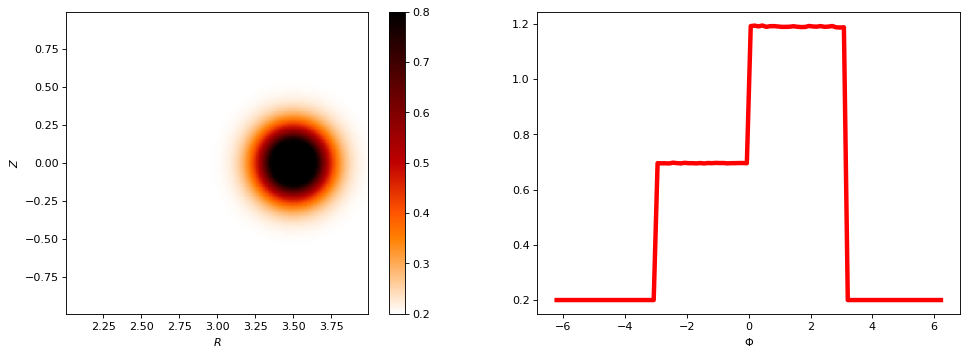

In [10]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3 
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,0,"blob_initial",vmin=0.2, vmax=0.8)

Running simulation a52a31...9390b9.nc
Running simulation a52a31...9390b9.nc
file : ThreeDimensional/data/a52a31bd5b388f420c73ee8b84d55196aa9390b9.nc
scheme = staggered-fieldaligned limiter = none time = 20.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 587.0, nfailed: 0.0
$3 \times 32 \times 50 \times 587 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=20$

Relative error in conserved quantities:
$\varepsilon_M=8.26e-05$
$\varepsilon_E=-4.50e-03$

interpolation/projection : linear-nearest
advection                : staggered-fieldaligned
nu_parallel              :  $0.0$


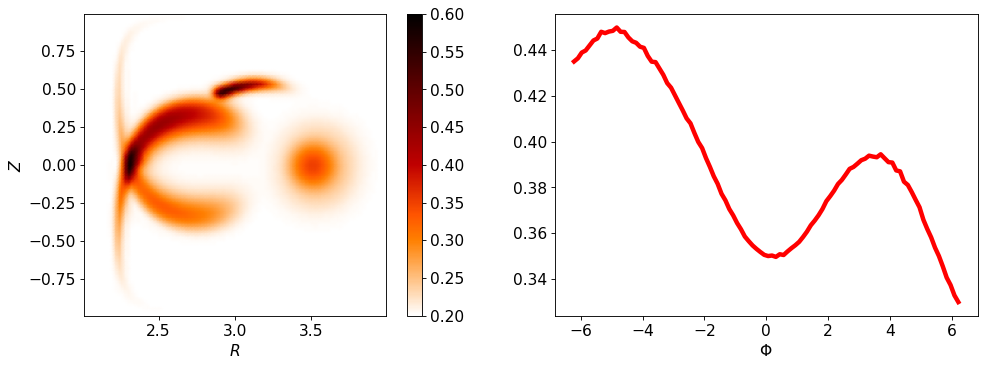

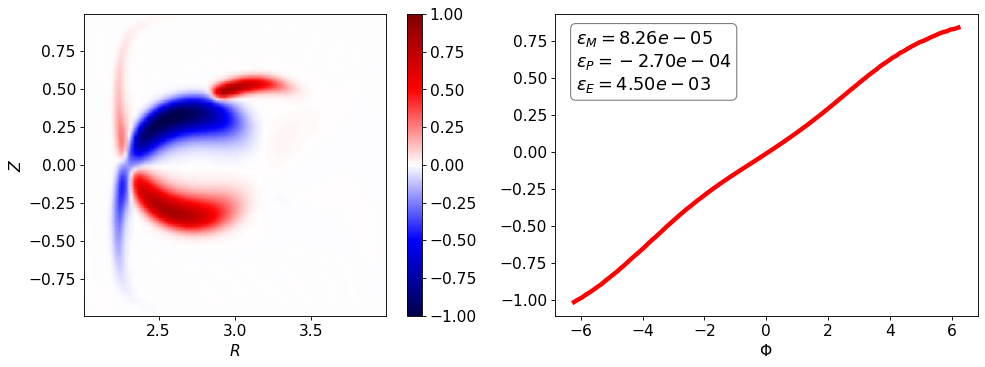

In [11]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-fieldaligned-linear-nearest",vmin=0.2, vmax=0.6)
plot_velocity(simfile,plotfile,1,"blob-staggered-fieldaligned-linear-nearest-u",vmin=-1.0,vmax=1.0)

Running simulation 23d5ca...b4d051.nc
Running simulation 23d5ca...b4d051.nc
file : ThreeDimensional/data/23d5ca30abd05647d5d269e009937a8b57b4d051.nc
scheme = staggered limiter = none time = 20.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 587.0, nfailed: 0.0
$3 \times 32 \times 50 \times 587 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=20$

Relative error in conserved quantities:
$\varepsilon_M=2.04e-08$
$\varepsilon_E=-4.59e-03$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


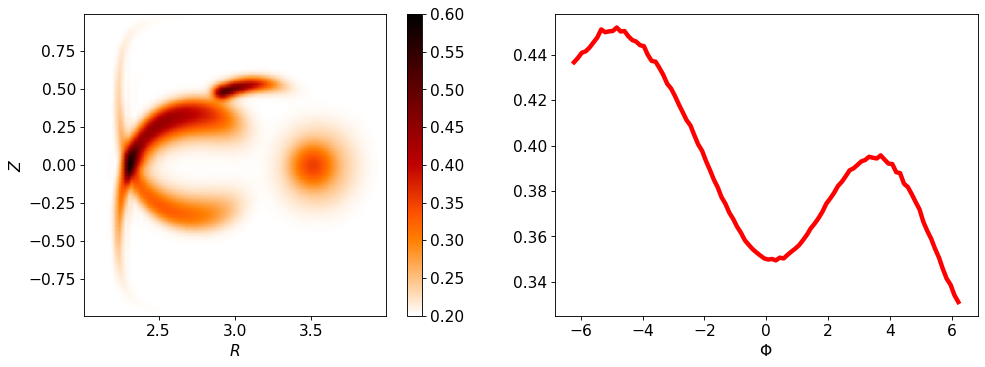

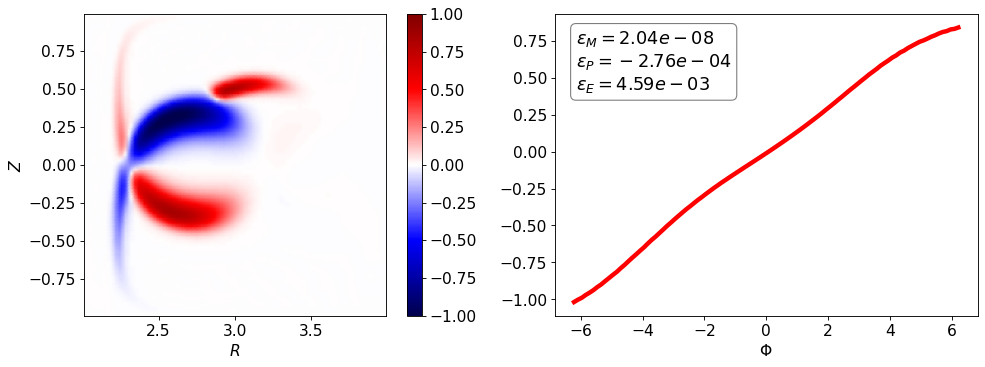

In [12]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-linear-nearest",vmin=0.2,vmax=0.6)
plot_velocity(simfile,plotfile,1,"blob-staggered-linear-nearest-u",vmin=-1.0,vmax=1.0)

Running simulation 662722...4df4c2.nc
Running simulation 662722...4df4c2.nc
file : ThreeDimensional/data/662722fdc1ce871569a30f1ef4767c7ba24df4c2.nc
scheme = staggered limiter = none time = 20.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: dg, nsteps: 602.0, nfailed: 0.0
$3 \times 32 \times 50 \times 602 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=20$

Relative error in conserved quantities:
$\varepsilon_M=-1.94e-05$
$\varepsilon_E=-3.65e-03$

interpolation/projection : dg
advection                : staggered
nu_parallel              :  $0.0$


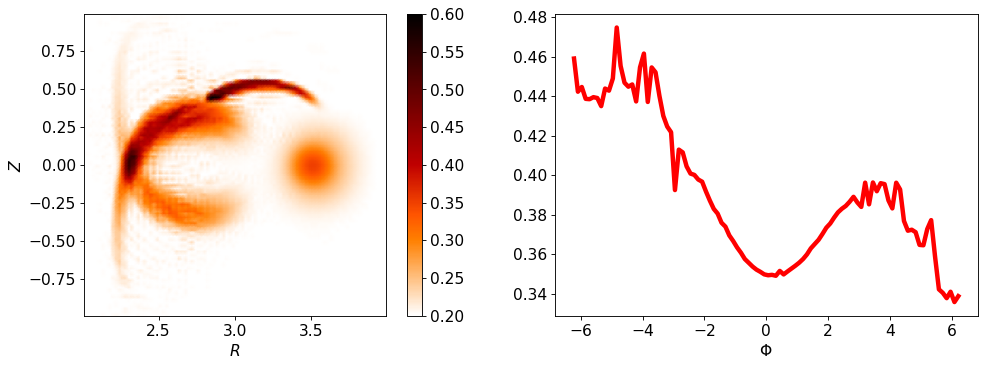

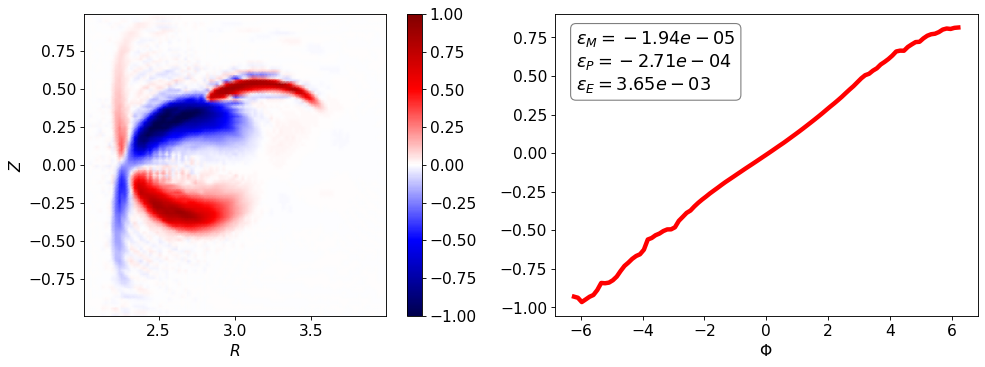

In [13]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "dg"
simulationfile["grid"]["n"] = 3 
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-dg-12",vmin=0.2,vmax=0.6)
plot_velocity(simfile,plotfile,1,"blob-staggered-dg-12-u",vmin=-1.0,vmax=1.0)

Running simulation b016f4...a4c9e9.nc
Running simulation b016f4...a4c9e9.nc
file : ThreeDimensional/data/b016f4ef71bdf7e8c0a6db6b8aafc4bb81a4c9e9.nc
scheme = staggered limiter = none time =  2.46
n: 3, Nx: 32, Nz: 50, mx: 1, method: dg, nsteps: 433.0, nfailed: 30.0
$3 \times 32 \times 50 \times 433 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=02$

Relative error in conserved quantities:
$\varepsilon_M=-8.40e-05$
$\varepsilon_E=-6.25e+05$

interpolation/projection : dg
advection                : staggered
nu_parallel              :  $0.0$


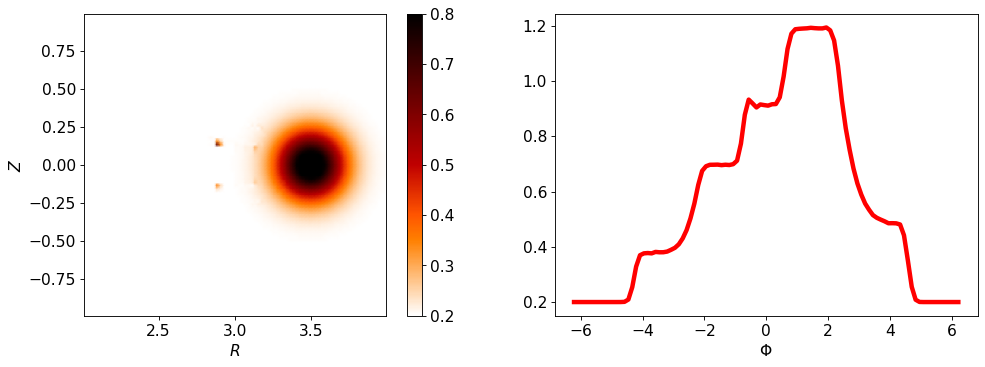

In [14]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [1,1]
simulationfile["FCI"]["interpolation-method"] = "dg"
simulationfile["grid"]["n"] = 3 
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-dg-1",vmin=0.2,vmax=0.8)

Now we test the same problem but with the circle initial condition

Running simulation e21d15...7c3b64.nc
Running simulation e21d15...7c3b64.nc
file : ThreeDimensional/data/e21d15350c043149ff7e9640c4f8e870ee7c3b64.nc
scheme = staggered limiter = none time =  0.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1.0, nfailed: 0.0
$3 \times 32 \times 50 \times 1 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=00$

Relative error in conserved quantities:
$\varepsilon_M=0.00e+00$
$\varepsilon_E=-0.00e+00$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


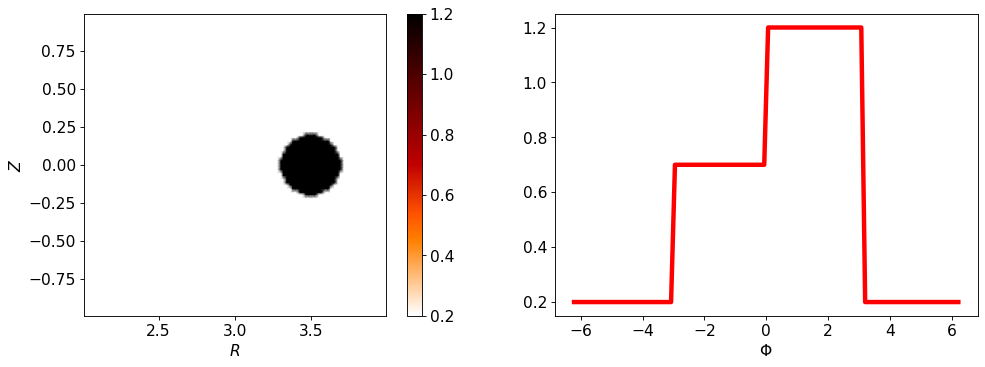

In [15]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered"
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3 # order 6 makes more oscis
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
# simfile =  simulator.create( simulationfile, error="display")
# plot2d(simulationfile)
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,0,"circle-initial",vmin=0.2,vmax=1.2)

Existing simulation e21d15...7c3b64.nc
Existing simulation e21d15...7c3b64.nc
file : ThreeDimensional/data/e21d15350c043149ff7e9640c4f8e870ee7c3b64.nc
scheme = staggered limiter = none time =  8.79
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1111.0, nfailed: 78.0
$3 \times 32 \times 50 \times 1111 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=08$

Relative error in conserved quantities:
$\varepsilon_M=-1.72e-07$
$\varepsilon_E=-2.68e+13$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


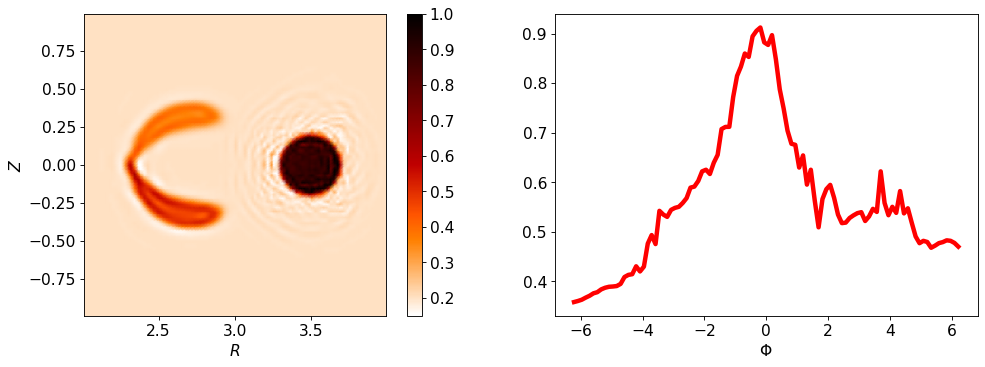

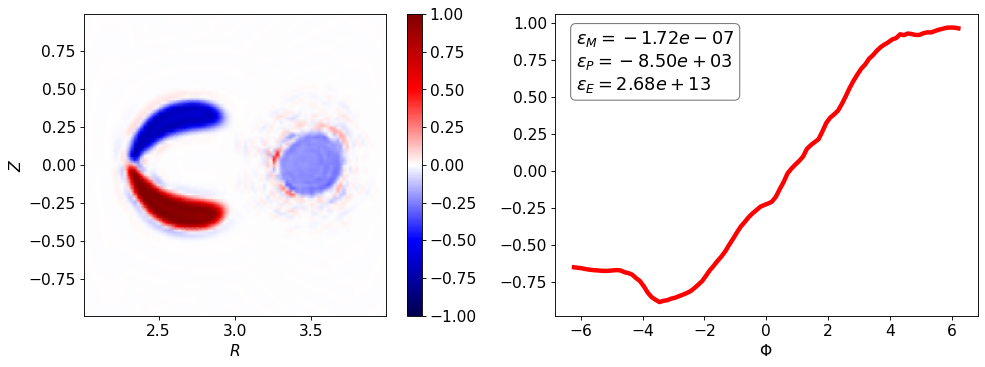

In [16]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered"
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3 # order 6 makes more oscis
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
# simfile =  simulator.create( simulationfile, error="display")
# plot2d(simulationfile)
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-staggered-linear-nearest",vmin=0.15,vmax=1.0)
plot_velocity(simfile,plotfile,1,"circle-staggered-linear-nearest-u",vmin=-1.0,vmax=1.0)

Running simulation 8d69fa...dc6919.nc
Running simulation 8d69fa...dc6919.nc
file : ThreeDimensional/data/8d69fa167833ad5ef06386135571970cf8dc6919.nc
scheme = staggered-fieldaligned limiter = none time = 30.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 914.0, nfailed: 0.0
$3 \times 32 \times 50 \times 914 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=30$

Relative error in conserved quantities:
$\varepsilon_M=3.93e-03$
$\varepsilon_E=-1.46e-02$

interpolation/projection : linear-nearest
advection                : staggered-fieldaligned
nu_parallel              :  $0.0$


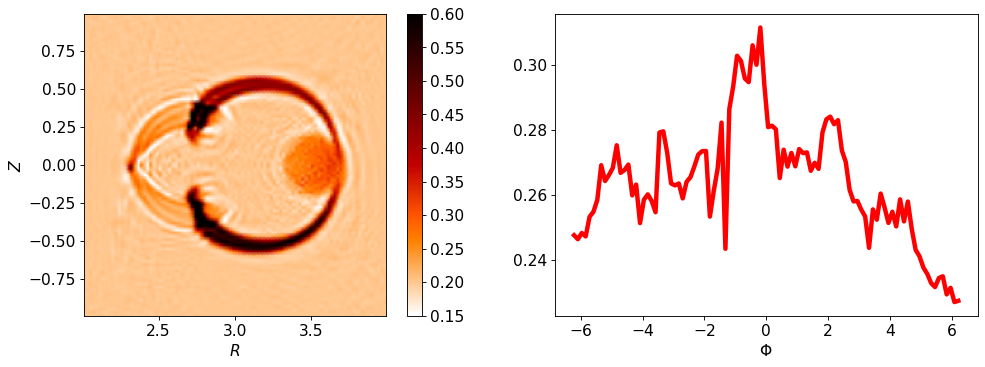

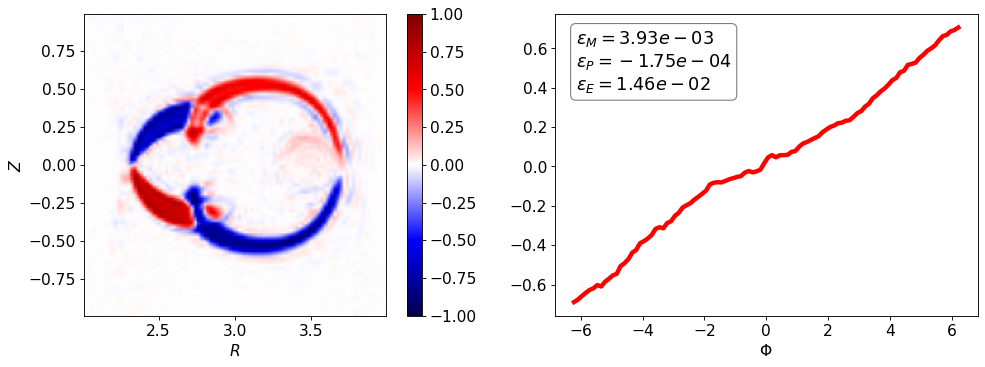

In [17]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 30
simulationfile["regularization"]["type"] = "none"
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-staggered-fieldaligned-linear-nearest",vmin=0.15,vmax=0.6)
plot_velocity(simfile,plotfile,1,"circle-staggered-fieldaligned-linear-nearest-u",vmin=-1.0,vmax=1.0)

The oscillations go away by adding parallel diffusion

Running simulation fba484...62b903.nc
Running simulation fba484...62b903.nc
file : ThreeDimensional/data/fba484565c930a6afe226f9f258560d56962b903.nc
scheme = velocity-staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 491.0, nfailed: 0.0
$3 \times 50 \times 20 \times 491 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=6.93e-07$
$\varepsilon_E=-2.37e-02$

interpolation/projection : linear-nearest
advection                : velocity-staggered
nu_parallel              :  $0.2$


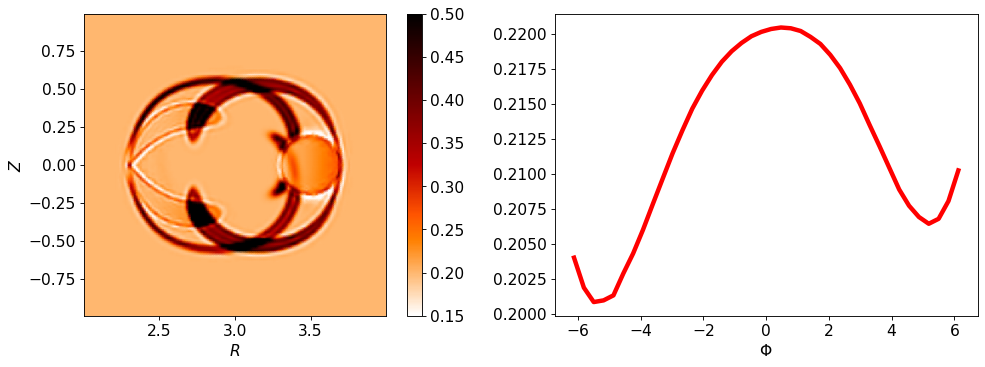

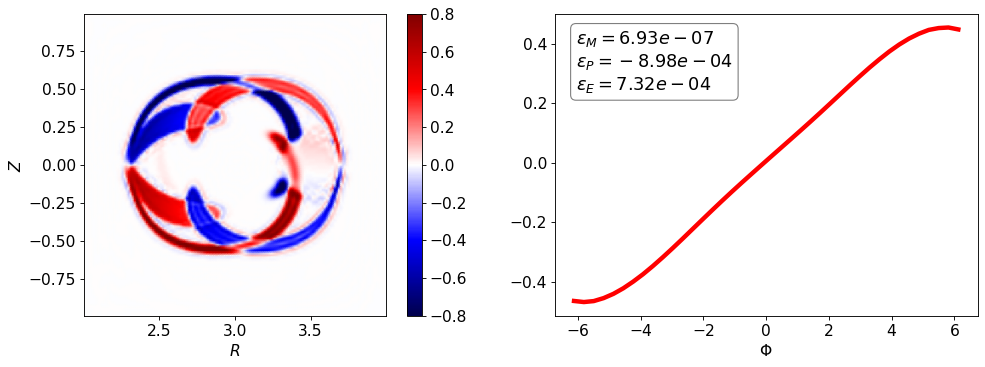

In [18]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["regularization"]["type"] = "none"
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)

simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-velocity-staggered-linear-nearest-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-velocity-staggered-linear-nearest-nu-u",vmin=-0.8,vmax=0.8)

Running simulation df17ed...648fe9.nc
Running simulation df17ed...648fe9.nc
file : ThreeDimensional/data/df17ed4f84dfb49d0a9f32f885280b5558648fe9.nc
scheme = velocity-staggered-fieldaligned limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 491.0, nfailed: 0.0
$3 \times 50 \times 20 \times 491 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=1.30e-03$
$\varepsilon_E=-2.60e-02$

interpolation/projection : linear-nearest
advection                : velocity-staggered-fieldaligned
nu_parallel              :  $0.2$


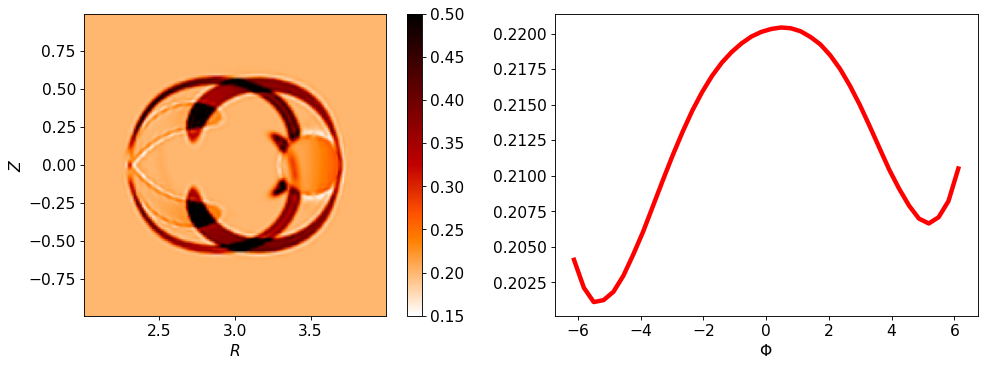

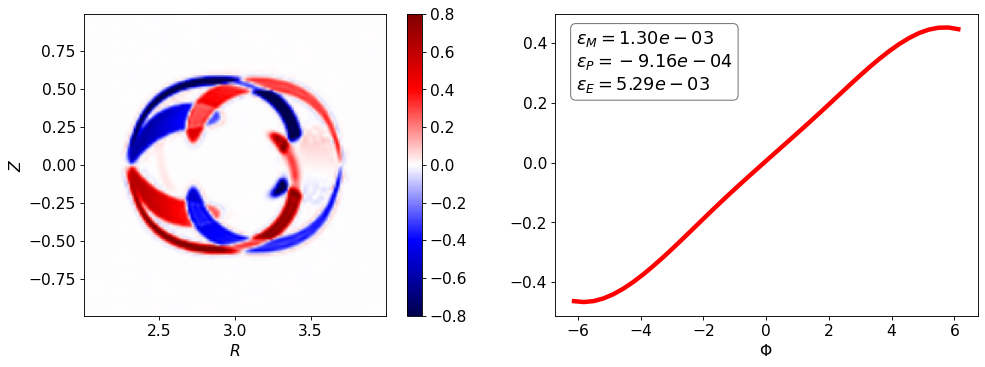

In [19]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["regularization"]["type"] = "none"
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-velocity-staggered-fieldaligned-linear-nearest-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-velocity-staggered-fieldaligned-linear-nearest-nu-u",vmin=-0.8,vmax=0.8)

Running simulation e674b3...1a02c1.nc
Running simulation e674b3...1a02c1.nc
file : ThreeDimensional/data/e674b310be492f86a650c9865a480009d11a02c1.nc
scheme = velocity-staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: dg, nsteps: 1184.0, nfailed: 69.0
$3 \times 50 \times 20 \times 1184 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=3.14e-06$
$\varepsilon_E=-2.72e-02$

interpolation/projection : dg
advection                : velocity-staggered
nu_parallel              :  $0.2$


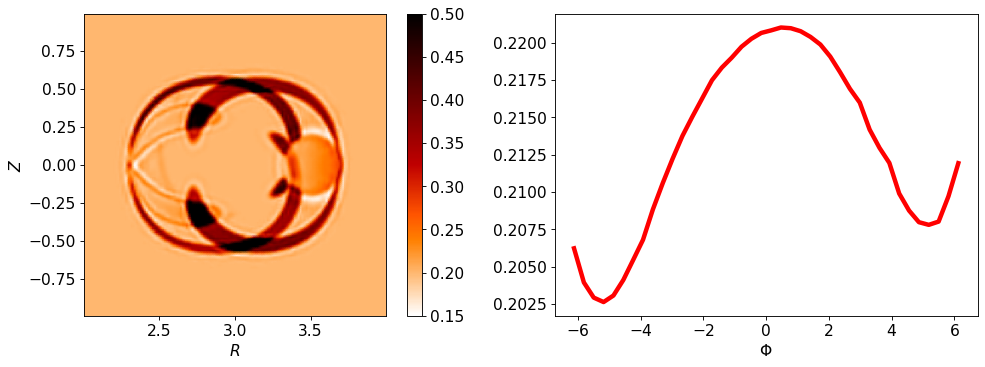

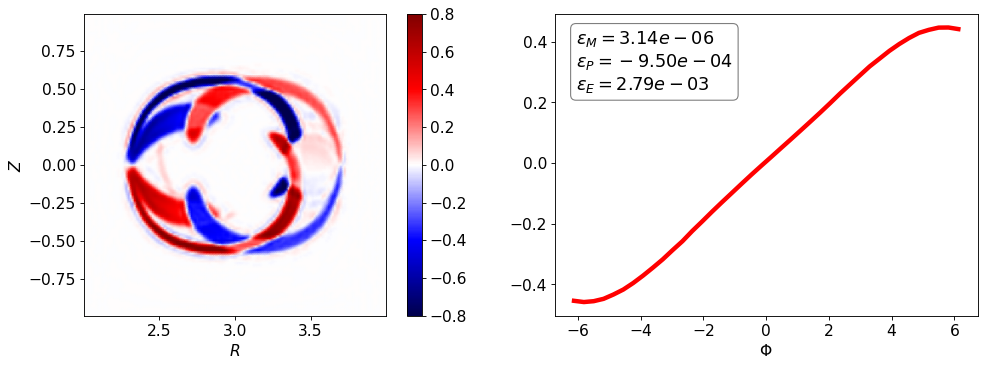

In [20]:
## Does dG still crash?
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "dg"
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["regularization"]["type"] = "none"
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-velocity-staggered-dg-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-velocity-staggered-dg-nu-u",vmin=-0.8,vmax=0.8)

Running simulation c939aa...6ba5fa.nc
Running simulation c939aa...6ba5fa.nc
file : ThreeDimensional/data/c939aae5873055b6d7e30d24a3938acb1d6ba5fa.nc
scheme = staggered-direct limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 488.0, nfailed: 0.0
$3 \times 50 \times 20 \times 488 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=-4.48e-03$
$\varepsilon_E=-1.84e-02$

interpolation/projection : linear-nearest
advection                : staggered-direct
nu_parallel              :  $0.2$


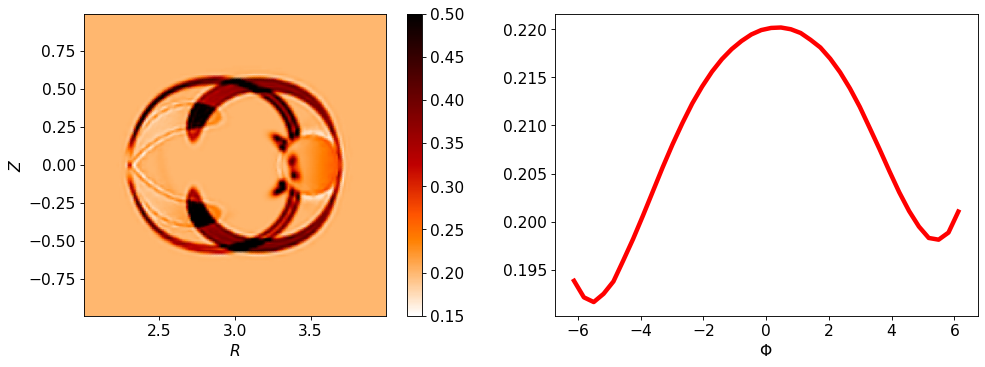

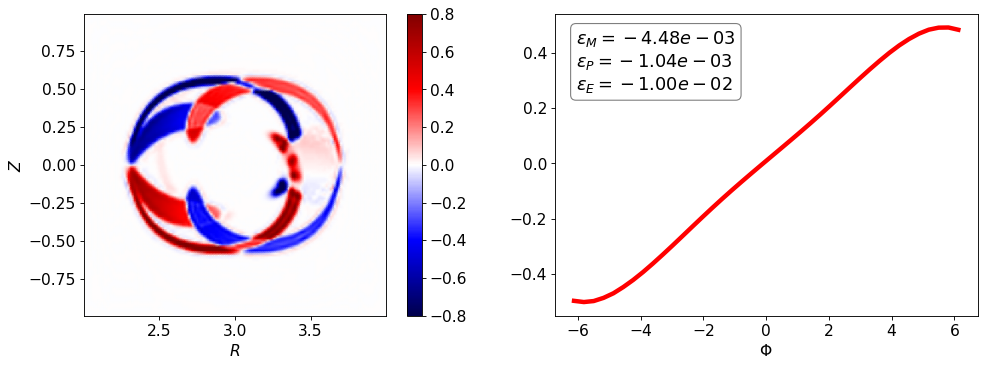

In [21]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-direct"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["regularization"]["type"] = "none"
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-staggered-direct-linear-nearest-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-staggered-direct-linear-nearest-nu-u",vmin=-0.8,vmax=0.8)

### Plot conservation of mass

In [22]:
# Define a plotting routine for the conservation equations
def plot_conservation( simfile_l, plot_velocity = False, save="", vmin=0.2, vmax=0.8):
    plt.rcParams.update({'font.size': 14})
    frows = 1
    fcols = 1
    if plot_velocity :
        fcols = 2
    
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.25*6,frows*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    for simfile in simfile_l :
        simset = Dataset( simfile[0], 'r', format="NETCDF4")
        pp = json.loads(simset.inputfile)

        vol = simset["vol2d"][:,:]
        time = simset['time'][:]
        print( f"file : {simfile}")
        print( f"scheme = {pp['advection']['type']}", end=" ")
        print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
        print(f"time = {time[np.size(time)-1]:5.2f}")
        gg = pp["grid"]
        fci = pp["FCI"]
        print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
        print( f", method: {fci['interpolation-method']}", end='')
        print( f", nsteps: {simset['nsteps'][np.size(time)-1]}, nfailed: {simset['failed'][np.size(time)-1]}")

        ####################################################################
        ####################################################################
        ####################################################################
        ####################################################################
        ####################################################################
        ####################################################################


        lower = vmin
        upper = vmax
        vo = simset['ions_ta2d'][:,:,:]
        mass0 = np.sum( vo[0,:,:]*vol )
        mass = np.sum( vo[:,:,:]*vol, axis=(1,2) )
    #     print( "Relative Mass error ", ((mass0-mass1)/mass0))
        vo = simset['nilnni_ta2d'][:,:,:] + simset["niui2_ta2d"][:,:,:]
        energy0 = np.sum( vo[0,:,:]*vol )
        energy = np.sum( vo[:,:,:]*vol, axis=(1,2) )
    #     print( "Relative Energy error ", ((energy0-energy1)/energy0)

        l = f"{pp['advection']['type']}"
        if pp['advection']['type'] == "velocity-staggered" :
            l = "velocity-staggered flux-centred"
        if pp['advection']['type'] == "velocity-staggered-fieldaligned" :
            l = "velocity-staggered value-centred"
        if pp['advection']['type'] == "staggered-direct":
            l = "staggered-direct (negative)"
        if pp['advection']['type']== "staggered":
            l = "staggered flux-centred (dg)"
        
        if plot_velocity :
            ax[0].plot( time, np.abs((mass0-mass)/mass0), ls = '-', color=simfile[1], lw = 4, label = l)
            ax[1].plot( time, np.abs((energy0-energy)/energy0), ls = '-', color=simfile[1],
                       lw = 4, label = l)
        else :
            ax.plot( time, np.abs((mass0-mass)/mass0), ls = '-', color=simfile[1], lw = 4, label = l)
        simset.close()
    
    if plot_velocity:
        ax[0].set_xlabel(r'$t$')
        ax[1].set_xlabel(r'$t$')
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_ylabel(r"$\varepsilon_M$")
        ax[1].set_ylabel(r"$\varepsilon_E$")
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].legend()
    else :
        ax.set_xlabel(r'$t$')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel(r"$\varepsilon_M$")
        ax.legend()
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     ax[1].text(0.05, 0.95, boxstr, transform=ax[1].transAxes, fontsize=16,
#         verticalalignment='top', bbox=props)
    
    
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    
    plt.show()

Running simulation 0a8c93...dd56b9.nc
Running simulation cee00a...a081f5.nc
Running simulation 21a39c...533b5d.nc
Running simulation ad861e...3c1b95.nc
file : ('ThreeDimensional/data/0a8c93b47b6213f8e35838cc3ca7035f4edd56b9.nc', 'c')
scheme = staggered-direct limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 475.0, nfailed: 2.0
file : ('ThreeDimensional/data/cee00ab4302e7105f23be690ba8a6f3ab5a081f5.nc', 'b')
scheme = velocity-staggered-fieldaligned limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 455.0, nfailed: 3.0
file : ('ThreeDimensional/data/21a39c52243fd91ddfc21cd866bdd70ff4533b5d.nc', 'g')
scheme = staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: dg, nsteps: 410.0, nfailed: 0.0
file : ('ThreeDimensional/data/ad861e701f5c9c4de0e31a014fba09c2243c1b95.nc', 'm')
scheme = velocity-staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps

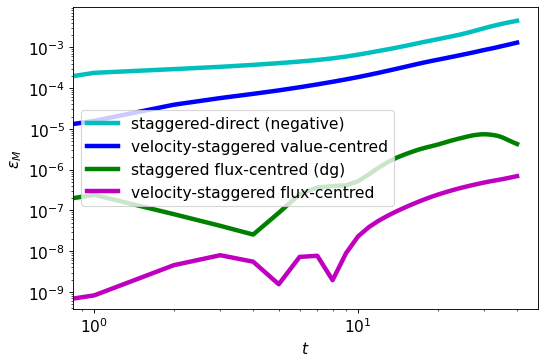

In [23]:
simfile_l = list()
for t in [ ("staggered-direct", "c", "linear-nearest"),
           ("velocity-staggered-fieldaligned","b", "linear-nearest"),
           ("staggered", "g", "dg" ),
           ("velocity-staggered", "m", "linear-nearest")]:
    #for K in [6,12]:
    K=12
    simulationfile = create_inputfile()

    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = t[0]
    simulationfile["physical"]["nu_parallel"] = [0,0.2]
    simulationfile["regularization"]["nu_parallel_n"] = 0.2
    simulationfile["FCI"]["refine"] = [K,K]
    simulationfile["FCI"]["interpolation-method"] = t[2]
    simulationfile["grid"]["n"] = 3
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = 20
    simulationfile["advection"]["slope-limiter"] = "none"
    simulationfile["timestepper"]["Tend"] = 40
    simulationfile["output"]["itstp"] = 1
    simulationfile["output"]["maxout"] = 40
    simulationfile["regularization"]["type"] = "none"
    # simfile =  simulator.create( simulationfile)
    # plot2d(simulationfile)

    simfile_l.append( (simulator.create( simulationfile, error="display"), t[1]))
plot_conservation(simfile_l, plot_velocity=False,save='mass_conservation')

### Fieldaligned derivatives
In this experiment we initialize a disc in the plane at $\varphi=0$. 
Then, we transform the disc along the fieldlines half around the torus in both directions.
We can then apply the FCI derivative. Analytically $\nabla_\parallel f=0$ except at both ends of the disc
where the derivatives diverge.

In the following we see that this is not true numerically.

In [24]:
def plot_lparallel( simulationfile, save=""):
    simfile = rep.create( simulationfile)
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc, yc = np.meshgrid( x, y)
    
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')
    im = ax.pcolormesh(xc, yc, ncin["lparallelinv_ta2d"][0,:,:],
                       vmin=0, vmax=0.08,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( r"$R$")
    ax.set_ylabel( r"$Z$")
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    plt.show()

Running simulation f64f0a...2d5dc6.nc
ThreeDimensional/calibrate/f64f0a525dcc4a8a2be03923dd304900492d5dc6.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: dg


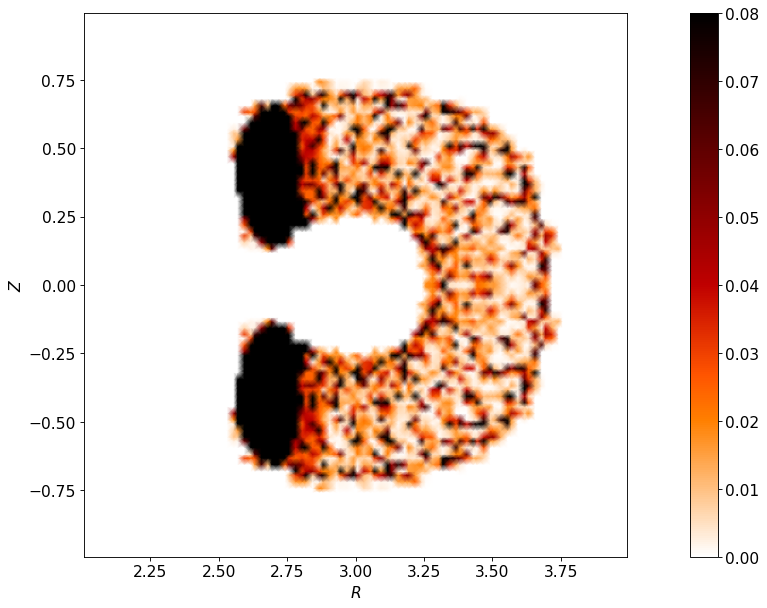

Running simulation 47218b...bb75af.nc
ThreeDimensional/calibrate/47218bdd190eb71ecb067abb98eb19e416bb75af.nc
n: 3, Nx: 32, Nz: 20, mx: 12, method: dg


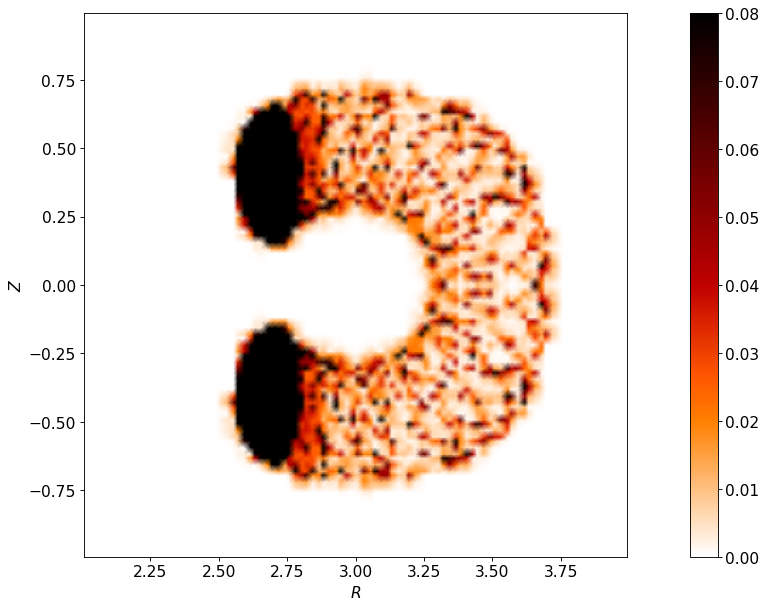

In [25]:
for method in ["dg"]:
    for mx in [1,12]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["init"]["density"]["ntilde"]["type"]="circle"
        simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]
        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot_lparallel(simulationfile,save="lparallel-dg-"+str(mx))

We now change the interpolation method to a bi-linear one, hoping that
less oscillations appear.

Running simulation 068354...5640ad.nc
ThreeDimensional/calibrate/068354e23079009c8d6b27f31ce1db57255640ad.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: linear-nearest


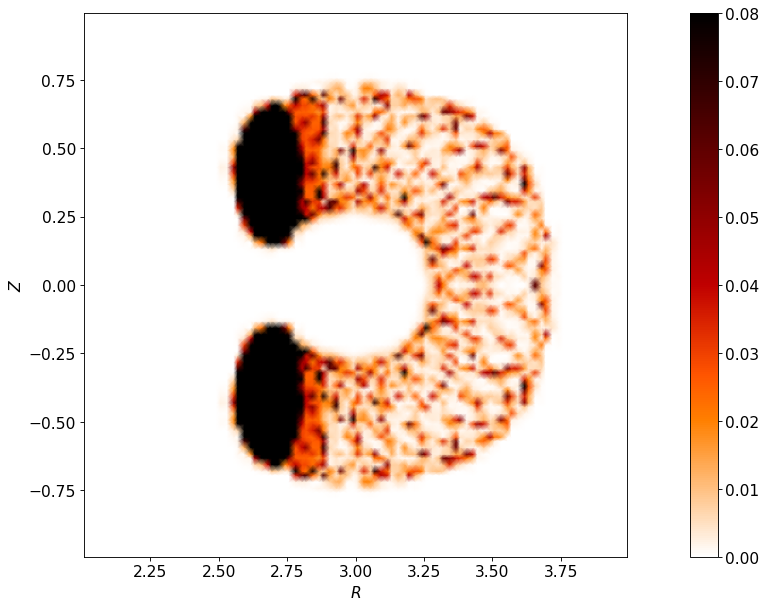

Running simulation 7d62ff...47faab.nc
ThreeDimensional/calibrate/7d62ffddd9d5e69a6228fbc36f326dad3447faab.nc
n: 3, Nx: 32, Nz: 20, mx: 12, method: linear-nearest


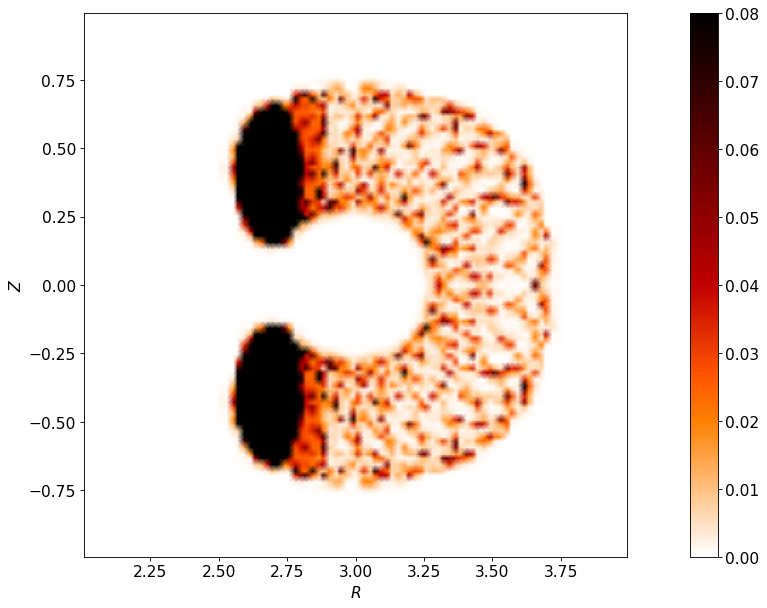

In [26]:
for method in ["linear-nearest"]:
    for mx in [1,12]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["init"]["density"]["ntilde"]["type"]="circle"
        simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]

        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot_lparallel(simulationfile,save="lparallel-linear-nearest-"+str(mx))

We can also try to increase the perpendicular resolution. We see that the oscillations become smaller in size but do not vanish (likely because the step is sharp).

Running simulation 35b2a9...fd1fca.nc
ThreeDimensional/calibrate/35b2a9b34c51b4b8e875fe871dabde1802fd1fca.nc
n: 3, Nx: 60, Nz: 20, mx: 1, method: linear-nearest


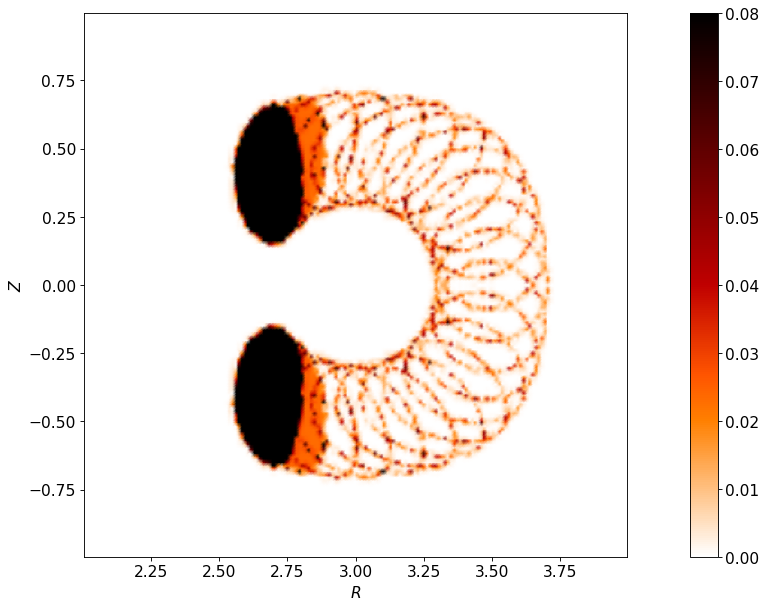

In [27]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
simulationfile["init"]["density"]["ntilde"]["type"]="circle"
simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
simulationfile["output"]["maxout"] = 0
simulationfile["advection"]["type"] = "centered"
simulationfile["physical"]["nu_parallel"] = [0,1]

simulationfile["FCI"]["refine"] = [1,1]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 60
simulationfile["grid"]["Ny"] = 60
simulationfile["grid"]["Nz"] = 20
plot_lparallel(simulationfile,"lparallel-linear-nearest-high-res")

We can also try to vary the number of polynomials in the dg interpolation method:
Clearly the higher the polynomial number the more oscillations appear.

Running simulation be0d70...28b656.nc
ThreeDimensional/calibrate/be0d709f9b877c4a980ea267cbe7f6309d28b656.nc
n: 2, Nx: 50, Nz: 20, mx: 5, method: dg


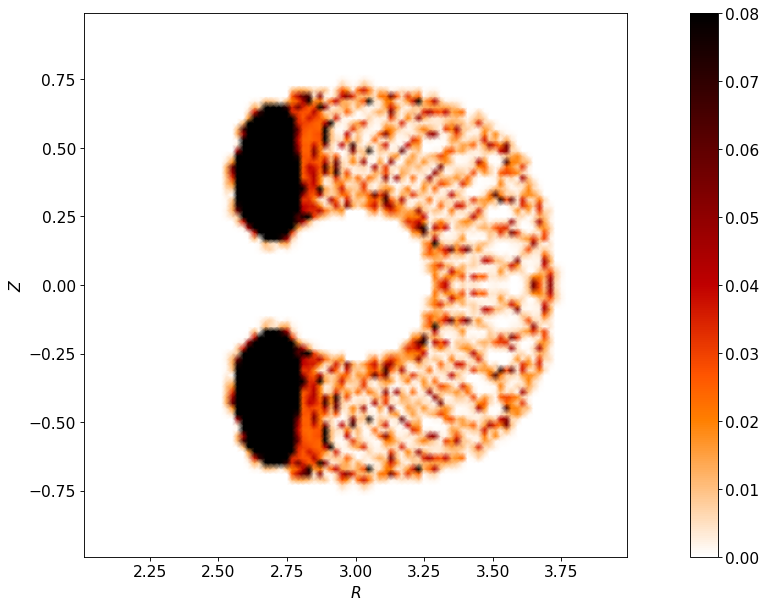

Running simulation 12b6d6...f466fd.nc
ThreeDimensional/calibrate/12b6d6acd85c0396bdd2e69b11cbcda51bf466fd.nc
n: 5, Nx: 20, Nz: 20, mx: 5, method: dg


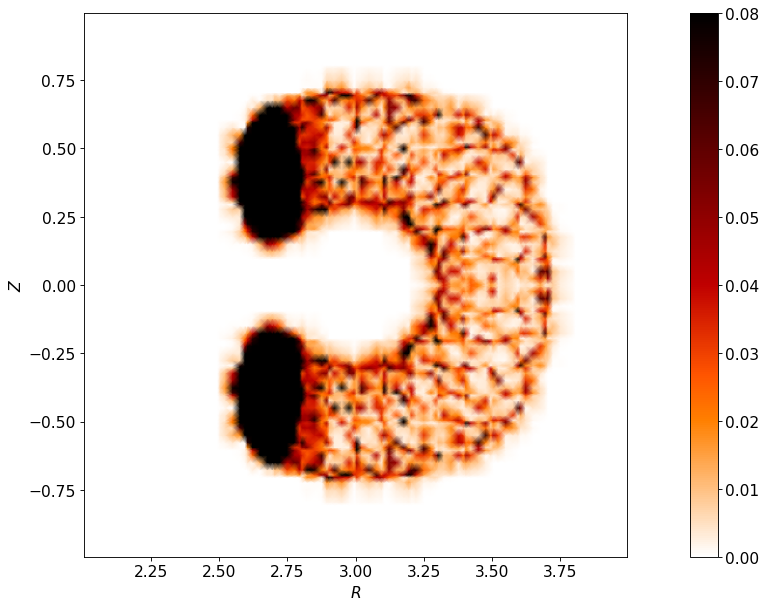

In [28]:
for n in [2,5] :
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
    simulationfile["init"]["density"]["ntilde"]["type"]="circle"
    simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
    simulationfile["output"]["maxout"] = 0
    simulationfile["advection"]["type"] = "centered"
    simulationfile["physical"]["nu_parallel"] = [0,1]

    simulationfile["FCI"]["refine"] = [5,5]
    simulationfile["FCI"]["interpolation-method"] = "dg"
    simulationfile["grid"]["n"] = n
    simulationfile["grid"]["Nx"] = 20
    simulationfile["grid"]["Ny"] = 20
    if n == 2 :
        simulationfile["grid"]["Nx"] = 50
        simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = 20
    plot_lparallel(simulationfile)

### Pure Diffusion test

On the diffusion problem:
- direct diffusion operator is unstable without support operator
- direct diffusion operator is stable with support operator

Running simulation a47c8d...cadfa9.nc
Running simulation 68ebd3...a05639.nc
Running simulation b8169f...e71abc.nc


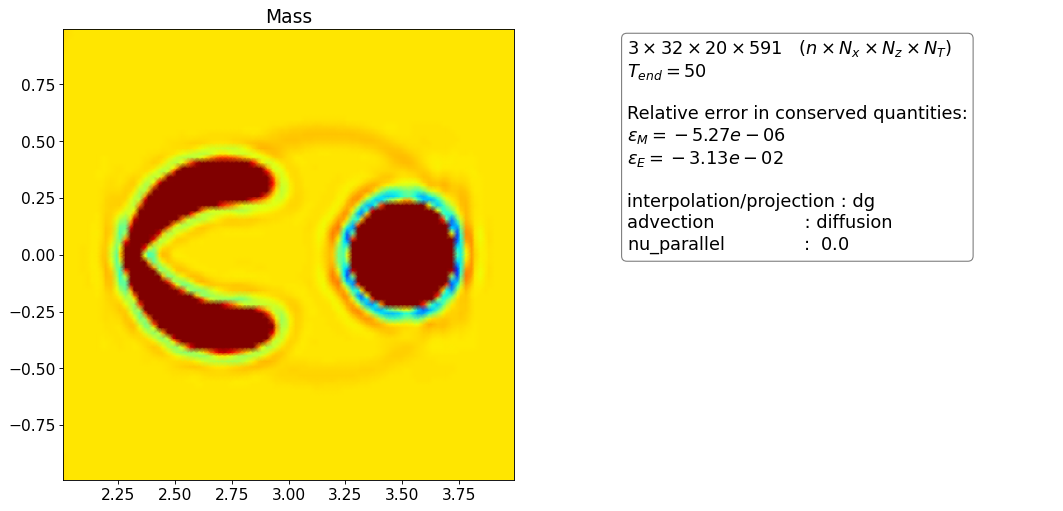

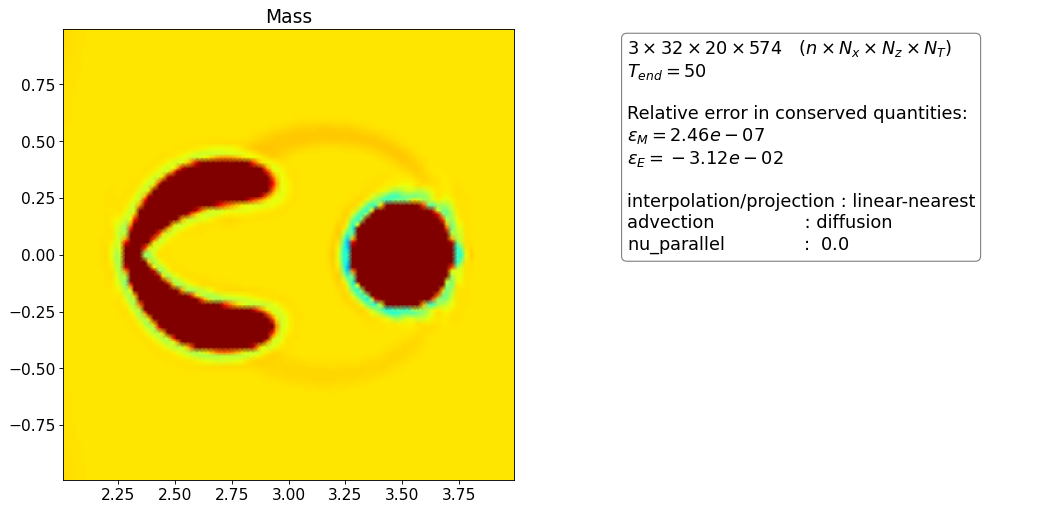

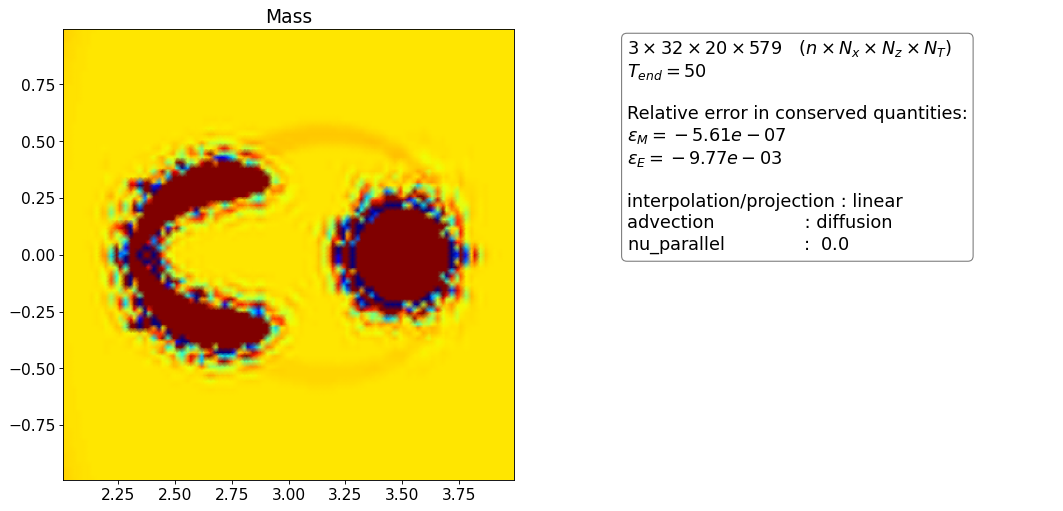

In [29]:
# First test pure diffusion 
for inter in ["dg","linear-nearest","linear"]:
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = "diffusion"
    simulationfile["regularization"]["nu_parallel_n"] = 1
    simulationfile["FCI"]["refine"] = [12,12]
    simulationfile["grid"]["n"] = 3
    simulationfile["grid"]["Nx"] = 32
    simulationfile["grid"]["Ny"] = 32
    simulationfile["grid"]["Nz"] = 20
    simulationfile["timestepper"]["Tend"] = 50
    simulationfile["FCI"]["interpolation-method"] = inter
    
    simfile = simulator.create( simulationfile, error = "display")
    plot2d( simulationfile)

Running simulation 390177...22e24b.nc
Running simulation 41c234...67e879.nc
Running simulation 8fc37d...f4c408.nc


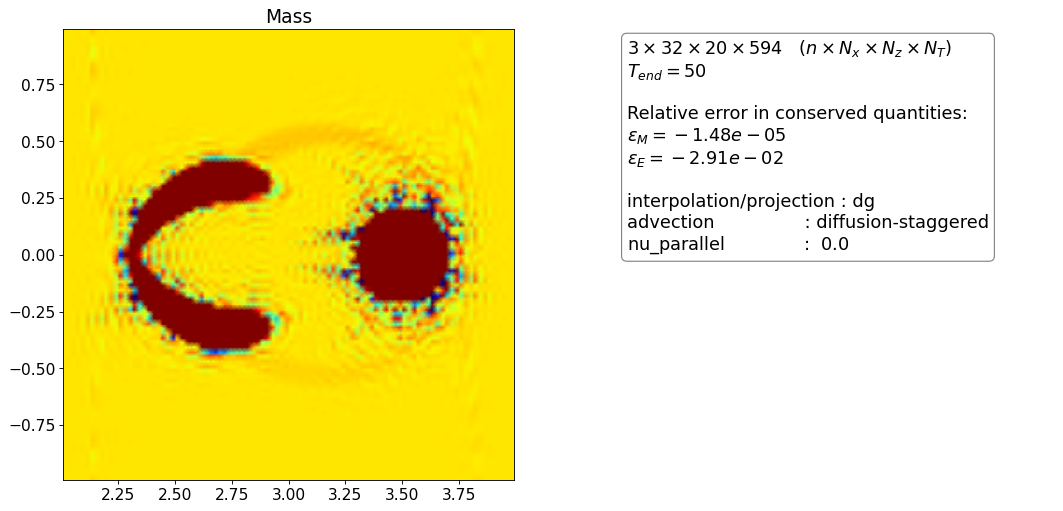

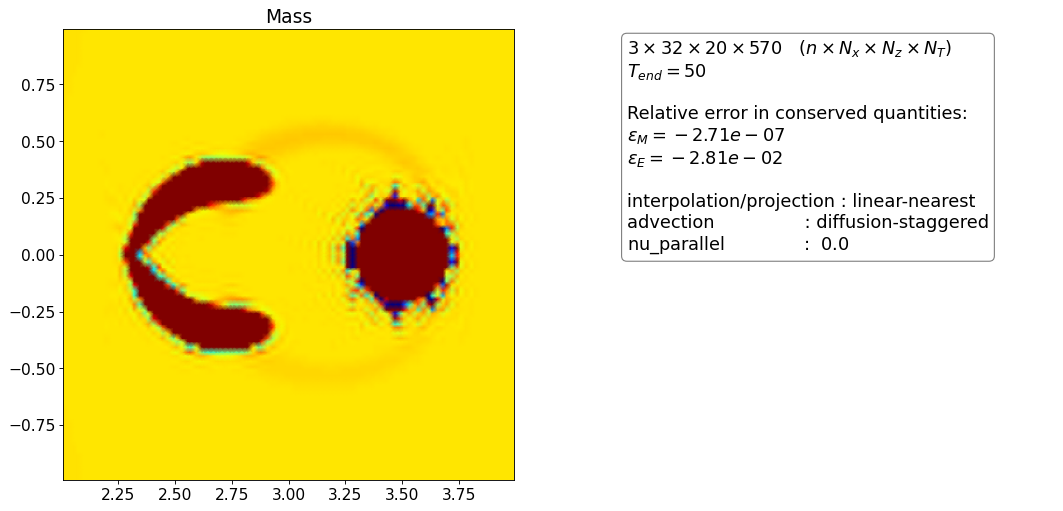

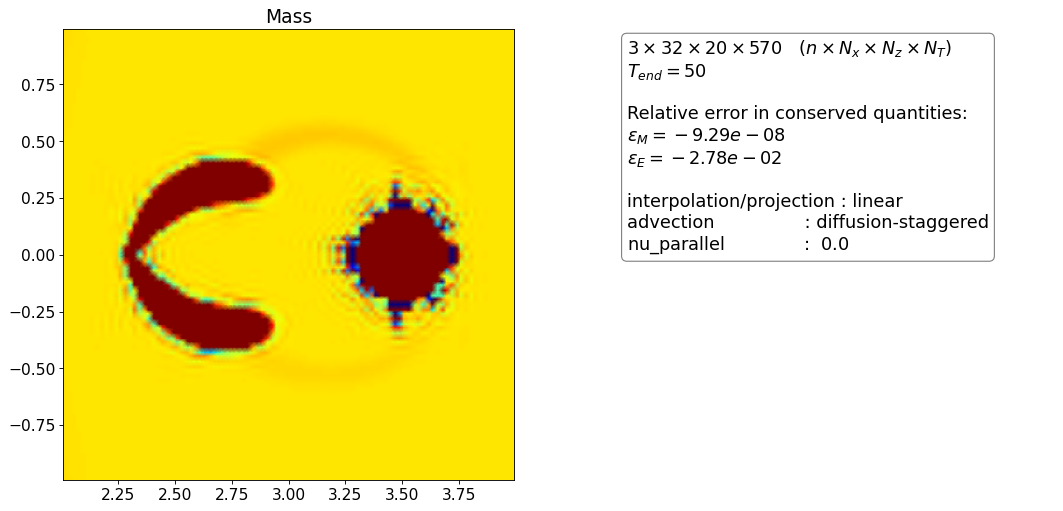

In [30]:
# First test pure diffusion 
for inter in ["dg","linear-nearest","linear"]:
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = "diffusion-staggered"
    simulationfile["regularization"]["nu_parallel_n"] = 1
    simulationfile["FCI"]["refine"] = [12,12]
    simulationfile["grid"]["n"] = 3
    simulationfile["grid"]["Nx"] = 32
    simulationfile["grid"]["Ny"] = 32
    simulationfile["grid"]["Nz"] = 20
    simulationfile["timestepper"]["Tend"] = 50
    simulationfile["FCI"]["interpolation-method"] = inter
    
    simfile = simulator.create( simulationfile)
    plot2d( simulationfile)